In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

sp_df = pd.read_csv('sp500_data.csv')
brent_df = pd.read_csv('Europe_Brent_Spot_Price.csv')
cvx_df = pd.read_csv('cvx_ohlcv_data.csv')

brent_df['Date'] = pd.to_datetime(brent_df['Date'])
cvx_df['Date'] = pd.to_datetime(cvx_df['Date'])
sp_df['Date'] = pd.to_datetime(sp_df['Date'])

# Initialize dictionaries to store aggregated results
total_null_counts = {}
total_missing_ratios = {}
total_rows = {}
total_columns = {}

# Count null values and calculate ratios for each dataframe
for df_name, df in [('Brent', brent_df), ('CVX', cvx_df), ('S&P 500', sp_df)]:
    null_counts = df.isnull().sum()
    total_rows[df_name] = len(df)
    total_columns[df_name] = len(df.columns)
    missing_ratio = null_counts / total_rows[df_name]
    
    total_null_counts[df_name] = null_counts.sum()
    total_missing_ratios[df_name] = total_null_counts[df_name] / (total_rows[df_name] * total_columns[df_name])
    
    for column, count in null_counts.items():
        if column not in total_null_counts:
            total_null_counts[column] = {}
            total_missing_ratios[column] = {}
        total_null_counts[column][df_name] = count
        total_missing_ratios[column][df_name] = missing_ratio[column]

# Create a DataFrame to display the aggregated results
null_analysis = pd.DataFrame({
    'Null Count': total_null_counts,
    'Missing Ratio': total_missing_ratios
})

# Display the aggregated results
print("Aggregated Null Value Analysis:")
print(null_analysis)

# Display total null values and overall missing ratio for each dataframe
for df_name in ['Brent', 'CVX', 'S&P 500']:
    print(f"\n{df_name} Dataset:")
    print(f"Total number of null values: {total_null_counts[df_name]}")
    print(f"Overall missing ratio: {total_missing_ratios[df_name]:.4f}")


# Calculate average S&P 500 price from all tickers
sp_df['Average Price'] = sp_df.groupby('Date')['Adj Close'].transform('mean')

# Merge the S&P 500 average price with the existing dataframe
brent_df = pd.merge(brent_df, sp_df[['Date', 'Average Price']], on='Date', how='left')

# Rename the column for clarity
brent_df = brent_df.rename(columns={'Average Price': 'SP500_Avg_Price'})

# Fill any missing values with forward fill method
brent_df['SP500_Avg_Price'] = brent_df['SP500_Avg_Price'].ffill()

# Merge the dataframes on the 'Date' column
merged_df = pd.merge(cvx_df, brent_df[['Date', 'Brent Price', 'SP500_Avg_Price']], on='Date', how='inner')

# Drop rows with missing data
merged_df = merged_df.dropna()

# Assign the merged dataframe back to cvx_df
df = merged_df
df.drop(columns=['Ticker'])

Aggregated Null Value Analysis:
                                       Null Count  \
Brent                                           0   
Date         {'Brent': 0, 'CVX': 0, 'S&P 500': 0}   
Brent Price                          {'Brent': 0}   
CVX                                             0   
Open                     {'CVX': 0, 'S&P 500': 0}   
High                     {'CVX': 0, 'S&P 500': 0}   
Low                      {'CVX': 0, 'S&P 500': 0}   
Close                    {'CVX': 0, 'S&P 500': 0}   
Adj Close                {'CVX': 0, 'S&P 500': 0}   
Volume                   {'CVX': 0, 'S&P 500': 0}   
Ticker                   {'CVX': 0, 'S&P 500': 0}   
S&P 500                                         0   

                                          Missing Ratio  
Brent                                               0.0  
Date         {'Brent': 0.0, 'CVX': 0.0, 'S&P 500': 0.0}  
Brent Price                              {'Brent': 0.0}  
CVX                                           

,Date,Open,High,Low,Close,Adj Close,Volume,Brent Price,SP500_Avg_Price
0,2020-10-26,71.730003,71.889999,70.239998,70.940002,59.750893,9710900.0,39.06,127.384757
1,2020-10-26,71.730003,71.889999,70.239998,70.940002,59.750893,9710900.0,39.06,127.384757
2,2020-10-26,71.730003,71.889999,70.239998,70.940002,59.750893,9710900.0,39.06,127.384757
3,2020-10-26,71.730003,71.889999,70.239998,70.940002,59.750893,9710900.0,39.06,127.384757
4,2020-10-26,71.730003,71.889999,70.239998,70.940002,59.750893,9710900.0,39.06,127.384757
...,...,...,...,...,...,...,...,...,...
480152,2024-09-27,142.979996,145.770004,142.839996,145.490005,145.490005,8047300.0,71.63,223.760519
480153,2024-09-27,142.979996,145.770004,142.839996,145.490005,145.490005,8047300.0,71.63,223.760519
480154,2024-09-27,142.979996,145.770004,142.839996,145.490005,145.490005,8047300.0,71.63,223.760519
480155,2024-09-27,142.979996,145.770004,142.839996,145.490005,145.490005,8047300.0,71.63,223.760519


Correlation between Close and Brent Price: 0.6479137452587833


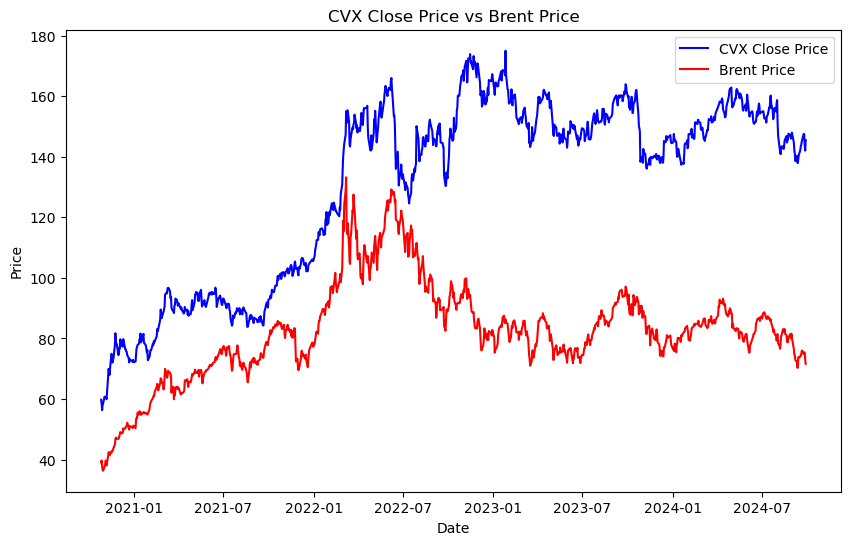

In [25]:
# Do correlation analysis on close price and brent price
correlation = df['Adj Close'].corr(df['Brent Price'])
print(f"Correlation between Close and Brent Price: {correlation}")

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Adj Close'], label='CVX Close Price', color='blue')
plt.plot(df['Date'], df['Brent Price'], label='Brent Price', color='red')
plt.title('CVX Close Price vs Brent Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.savefig('cvx_brent_price_comparison.png', dpi=300, bbox_inches='tight')
plt.legend()
plt.show()

Correlation between Normalized Close and Normalized Brent Price: 0.6479137452587929


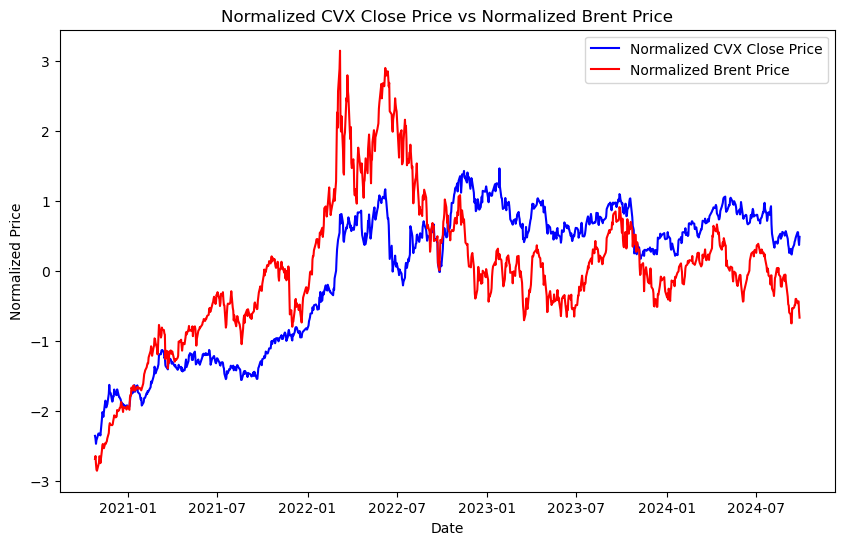

In [26]:
# Normalize the 'Close' and 'Brent Price' columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[['Adj Close', 'Brent Price']])

# Create a new DataFrame with normalized data
normalized_df = pd.DataFrame(normalized_data, columns=['Normalized Close', 'Normalized Brent Price'])

# Calculate correlation between normalized columns
correlation_normalized = normalized_df['Normalized Close'].corr(normalized_df['Normalized Brent Price'])
print(f"Correlation between Normalized Close and Normalized Brent Price: {correlation_normalized}")

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], normalized_df['Normalized Close'], label='Normalized CVX Close Price', color='blue')
plt.plot(df['Date'], normalized_df['Normalized Brent Price'], label='Normalized Brent Price', color='red')
plt.title('Normalized CVX Close Price vs Normalized Brent Price')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.savefig('normalized_cvx_brent_price_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Correlation between Normalized Adj Close and Normalized SP500 Avg Price: 0.4040151061237005
Correlation between Normalized Adj Close and Normalized Brent Price: 0.6479137452587929


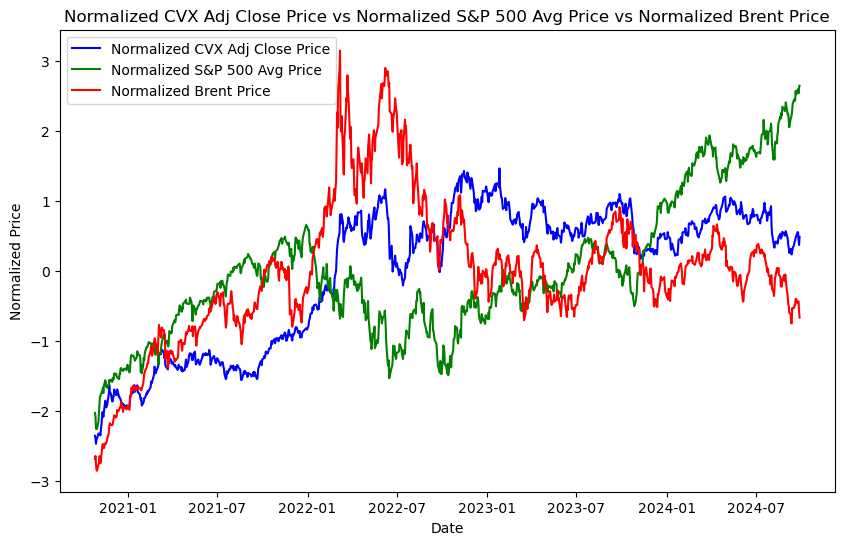

In [28]:
# Normalize the 'Adj Close', 'SP500_Avg_Price', and 'Brent Price' columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[['Adj Close', 'SP500_Avg_Price', 'Brent Price']])

# Create a new DataFrame with normalized data
normalized_df = pd.DataFrame(normalized_data, columns=['Normalized Adj Close', 'Normalized SP500 Avg Price', 'Normalized Brent Price'])
normalized_df['Date'] = df['Date']

# Calculate correlations between normalized columns
corr_cvx_sp500 = normalized_df['Normalized Adj Close'].corr(normalized_df['Normalized SP500 Avg Price'])
corr_cvx_brent = normalized_df['Normalized Adj Close'].corr(normalized_df['Normalized Brent Price'])
print(f"Correlation between Normalized Adj Close and Normalized SP500 Avg Price: {corr_cvx_sp500}")
print(f"Correlation between Normalized Adj Close and Normalized Brent Price: {corr_cvx_brent}")

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(normalized_df['Date'], normalized_df['Normalized Adj Close'], label='Normalized CVX Adj Close Price', color='blue')
plt.plot(normalized_df['Date'], normalized_df['Normalized SP500 Avg Price'], label='Normalized S&P 500 Avg Price', color='green')
plt.plot(normalized_df['Date'], normalized_df['Normalized Brent Price'], label='Normalized Brent Price', color='red')
plt.title('Normalized CVX Adj Close Price vs Normalized S&P 500 Avg Price vs Normalized Brent Price')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.savefig('normalized_cvx_sp500_brent_price_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Correlation between Normalized Volume and Normalized Adj Close: -0.19448296010172192


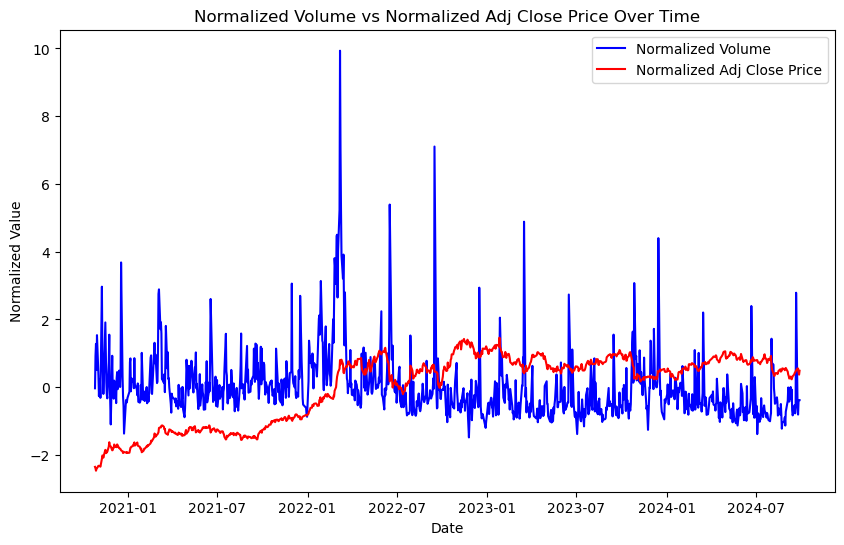

In [30]:
# Normalize the 'Volume' and 'Adj Close' columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[['Volume', 'Adj Close']])

# Create a new DataFrame with normalized data
normalized_df = pd.DataFrame(normalized_data, columns=['Normalized Volume', 'Normalized Adj Close'])
normalized_df['Date'] = df['Date']

# Calculate correlation between normalized columns
correlation = normalized_df['Normalized Volume'].corr(normalized_df['Normalized Adj Close'])
print(f"Correlation between Normalized Volume and Normalized Adj Close: {correlation}")

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(normalized_df['Date'], normalized_df['Normalized Volume'], label='Normalized Volume', color='blue')
plt.plot(normalized_df['Date'], normalized_df['Normalized Adj Close'], label='Normalized Adj Close Price', color='red')
plt.title('Normalized Volume vs Normalized Adj Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()

plt.savefig('normalized_volume_vs_adj_close_over_time.png', dpi=300, bbox_inches='tight')
plt.show()


Correlation between Normalized Open and Normalized Close: 0.9978187714122451


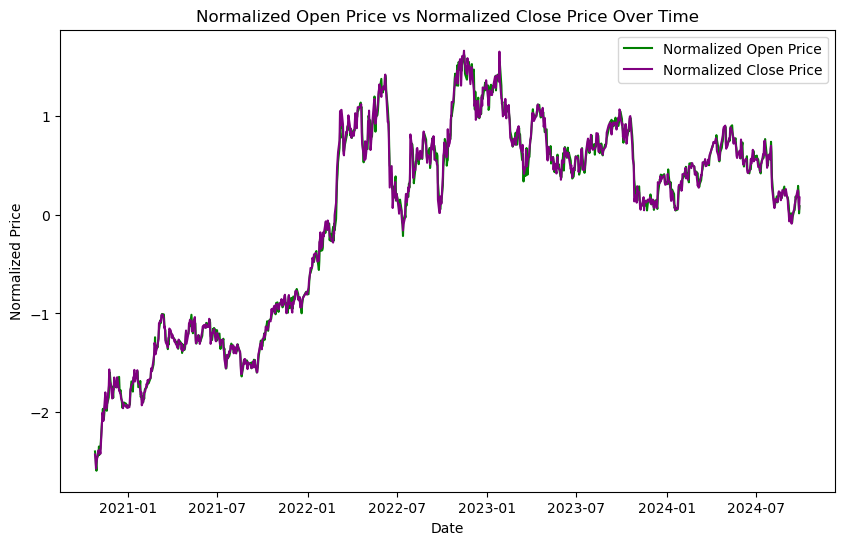

In [31]:
# Normalize the 'Open' and 'Close' columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[['Open', 'Close']])

# Create a new DataFrame with normalized data
normalized_df = pd.DataFrame(normalized_data, columns=['Normalized Open', 'Normalized Close'])
normalized_df['Date'] = df['Date']

# Calculate correlation between normalized columns
correlation = normalized_df['Normalized Open'].corr(normalized_df['Normalized Close'])
print(f"Correlation between Normalized Open and Normalized Close: {correlation}")

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(normalized_df['Date'], normalized_df['Normalized Open'], label='Normalized Open Price', color='green')
plt.plot(normalized_df['Date'], normalized_df['Normalized Close'], label='Normalized Close Price', color='purple')
plt.title('Normalized Open Price vs Normalized Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()

plt.savefig('normalized_open_vs_close_over_time.png', dpi=300, bbox_inches='tight')
plt.show()
